## Functions

In [ ]:
fontsize = 13

##### Initialization

In [ ]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)

# Convert currencies
#!pip install currencyconverter
#from currency_converter import CurrencyConverter

# Convert strings with commas as thousand separators
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') 

# Convert datatimes
from datetime import datetime

# Read zips
from zipfile import ZipFile

# Forecast models
#!pip install -U statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Scipy
from scipy.stats import *

# Warnings
import warnings

def mount_drive_select_path(drive_path = "/content/drive/MyDrive/UA/5º Ano/Tese"):

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Drive path
  %cd $drive_path

##### Read data

In [ ]:
def zip_2_dataframe(zip_name, file_name, filetype):
  
  # Open zip file
  zip_file = ZipFile(zip_name, 'r')  

  # Open file
  data_file = zip_file.open(file_name)

  if filetype == "csv":
    df = pd.read_csv(data_file)
  if filetype == "json":
    df = pd.read_json(data_file, lines=True)

  return df

##### Data cleaning

In [ ]:
# Convert a string to datetime data format
def str_2_date(str_date, date_format):
  return datetime.strptime(str(str_date), date_format)

# Replace the last ocurrence of a char in a string by another char
def replace_last_occurrence(str, old_char, new_char):
  
  last_index = str.rfind(old_char)
  if last_index == -1:    # the char wasn't found
    return str
  else:
    return str[:last_index] + new_char + str[last_index+1:]


# Remove commas, dots and currency signs from the prices
def clean_prices(price):

  # Sol peruano (doesn't have decimal cases - thousands are separated with commas)
  if price[0] == "S":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[2:])                              # remove the sign of the currency
    return price
  
  # Dollar (always has decimal cases (i think) - thousands and decimals are both separated by commas)
  if price[0] == "$":
    price = replace_last_occurrence(price, ",", ".")      # replace comma that separates decimals by a dot
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price
  
  # Euro (decimal cases, if there are any, are separated by dots - thousands are separated by commas)
  if price[0] == "€":
    price = price.replace(",", "")                        # remove commas that separate thousands
    price = float(price[1:])                              # remove the sign of the currency
    return price                              
  
  return np.nan


# Convert all prices to a base currency (euro)
def convert_prices_to_euros(row, currency_column, price_column, sol = 0.24, dollar = 1/1.0993):

  currency = row[currency_column]
  price = row[price_column]
  
  if currency in ["€"]:
    return price

  if currency in ["$"]:
    return dollar*price 
  
  if currency in ["S"]:
    return sol*price 


def clean_data(df):

  df = df.copy()
  
  # Convert timestamps' strings to data of date format
  df["timestamp"] = df["timestamp"].apply(str_2_date, args = ('%Y%m%d',))

  # Get type of currency
  df["currency"] = df["price"].str[0]

  # Clean prices (remove commas, dots, and currency signs)
  df["price_clean"] = df["price"].apply(clean_prices)

  # Convert all prices to a base currency (euro)
  df["price_euro"] = df.apply(convert_prices_to_euros, args = ("currency", "price_clean"), axis = 1)

  return df

##### Select time series

In [ ]:
# Select a particular time series based on its ID - ID can be of type: product_id, product_group_id, company_id

def select_time_series(df, id_type, id, price = "price_euro"):

  df = df.copy()

  # Select all rows that have id
  df = df[df[id_type].isin(id)]
  
  # Information about the selected products
  info = {
      "product_id": list(df["product_id"].unique()),
      "product_group_id": list(df["product_group_id"].unique()),
      "company_id": list(df["company_id"].unique()),
      "product": list(df["product"].unique()),
      "country_company": list(df["country_company"].unique()),
      "offer_type": list(df["offer_type"].unique())
      }
  
  return df, info

In [ ]:
def prepare_time_series_univariate(df, price = "price_euro", interpolate_method = "linear"):
  df = df.copy()
  df = df[["timestamp", price]].set_index("timestamp")

  df = fill_miss_vals(df)
  #df = add_stock_info(df)

  df[price] = interpolate(df["price_euro"], method = interpolate_method)

  return df

##### Transform data series

In [ ]:
# Apply differences to a time series
def diff_time_series(df, diff_order, columns = "all"):
  
  # diff_order - how many times data must be differenced
  # columns - list of the names of columns that will be differenced

  df = df.copy()

  if columns == "all":
    columns = df.columns

  for order in range(diff_order):
    df[columns] = df[columns].diff()
  
  df = df.dropna()

  return df

##### Add unique identifiers to data

In [ ]:
def create_id(df, id_name, unique_identifiers, loc = 0):
  df = df.copy()
  df.insert(loc=loc, column=id_name, value=df.set_index(unique_identifiers).index.factorize()[0]+1)
  return df

def add_ids(df):
  df = df.copy()

  df = create_id(df, "product_id", ['company','country','product','offer_type'])
  df = create_id(df, 'product_group_id', ['product','offer_type'])
  df = create_id(df, 'company_id', ['company','country'])
  df.insert(loc=0, column='country_company', value= df.country + " " + df.company)

  return df

##### Order time series by number of changes

In [ ]:
# def get_ordered_number_of_changes(df):
  
#   df_changes = pd.DataFrame({'n_changes' : df.groupby('product_id')['price_clean'].nunique()}).reset_index().sort_values(by = "n_changes", ascending = False)  
#   product_id_ord = df_changes["product_id"].to_numpy()

#   return df_changes, product_id_ord

def get_ordered_number_of_changes(df, id, time, value):
  
  df = df.copy()
  df = df[[id, value, time]].sort_values([id, time])                            # Order rows of dataframe by id and by time
  df["n_changes"] = df.groupby(id)[value].diff()                                # Group the rows of dataframe by id and then difference the consecutive rows of each group
  df = df.iloc[1:]                                                              # Remove the first row of the dataframe, as it is an NaN
  df = df.groupby(by = id)["n_changes"].agg(lambda x: x.ne(0).sum())            # Count how many differences are different than zero. This number will correspond to the number of changes in the timeseries
  product_id_ord = df.sort_values(ascending = False).index.to_numpy()           # Get a list of product_ids ordered by number of changes

  return df, product_id_ord

##### Missing values

In [ ]:
def add_stock_info(df, price = "price_euro"):
  df = df.copy()
  df["days_out_of_stock"] = df[price].isna().astype(int).groupby(df[price].notnull().astype(int).cumsum()).cumsum()
  df["out_of_stock"] = df[price].isna().astype(int)
  return df

# Add the days that are not present in a certain time series
def fill_miss_vals(df, time_column_name = "timestamp"):

  # df - data of a single time series
  # time_column_name - name of the column with the information of timestamps

  df = df.copy()

  idx = pd.date_range(min(df.index), max(df.index))
  df = df.reindex(idx, fill_value=np.nan)
  df.index.name = time_column_name

  return df

# Interpolation
def interpolate(df, method):
  return df.copy().interpolate(method =method, limit_direction ='forward')  

##### Visualize data

In [ ]:
# Set size of plot
def set_fig_size(size):
  plt.rcParams['figure.figsize'] = size

# Plot the time series of individual products
def show_time_series_product(df, info, price):
  
  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o')
  
  if len(product_id) == 1:
    ax.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
    print("Number of samples: ", len(df))

# Plot the time series of all products that belong to a certain group
def show_time_series_product_group(df, info, price):

  df = df.copy()

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "country_company", data=df, marker = 'o')
  ax.set_title(info["product"][0] + " - " + info["offer_type"][0]);

# Plot the time series that belong to a certain company from a certain country
def show_time_series_country_company(df, info, price):

  df = df.copy()

  with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    df["product_id"] = df["product_id"].astype('category')

  plt.rcParams['figure.figsize'] = (10, 5)
  ax = sns.lineplot(x="timestamp", y=price, hue = "product_id", data=df, marker = 'o', legend = False)
  ax.set_title(info["country_company"][0]);


def show_time_series(df, id_type, info, price = "price_euro"):

  df = df.copy()
  
  if id_type == "product_id":
    show_time_series_product(df, info, price)
  if id_type == "product_group_id":
    show_time_series_product_group(df, info, price)
  if id_type == "company_id":
    show_time_series_country_company(df, info, price)

##### Performance Metrics

In [ ]:
def get_nmse(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))

  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  nmse = 20*np.log10(np.sqrt(sum((y_obs-y_pred)**2)/sum(y_obs**2)))

  return nmse[0]

In [ ]:
def get_mape(y_obs, y_pred):
  y_obs = y_obs.to_numpy().reshape((y_obs.shape[0], 1))
  y_pred = y_pred.to_numpy().reshape((y_pred.shape[0], 1))
  
  if len(y_obs) != len(y_pred):
    print("The lenghts of the input arrays don't match.")

  n = len(y_obs)
  mape = 1/n*sum(abs((y_obs-y_pred)/y_obs))

  return mape[0]

##### Save figure

In [ ]:
def save_fig(plt, chapter_name, section_name, name_of_fig):
  path = 'Dissertação/Chapters/Imagens/Chapter_' + chapter_name + "/" + str.lower(chapter_name) + "_" + str.lower(section_name) + "_" + name_of_fig + "."
  print(path)
  plt.savefig(path + "svg")
  plt.savefig(path + "png", bbox_inches = "tight")
  plt.savefig(path + "pdf")

# Notebook: Naive models

- **Goal**: study of naive models and choice of baseline model

In [ ]:
mount_drive_select_path()

Mounted at /content/drive
/content/drive/MyDrive/UA/5º Ano/Tese


### Read data

#### Read df_all

In [ ]:
df_all = pd.read_pickle("df_all")

In [ ]:
n_samples = df_all.dropna().groupby(by = "product_id").count().price_euro
n_changes = df_all.dropna()["diff"]
n_changes = n_changes[n_changes != 0].groupby(by = "product_id").count()
n_samples = n_samples.loc[n_changes.index]

In [ ]:
min_n_changes = 5
min_n_samples = 90

n_changes_flt = n_changes[n_changes > min_n_changes]
n_samples_flt = n_samples.loc[n_changes_flt.index]
n_samples_flt = n_samples_flt[n_samples_flt > min_n_samples]
n_changes_flt = n_changes_flt.loc[n_samples_flt.index]
changes_samples_ratio_flt = n_changes_flt/n_samples_flt

In [ ]:
df_flt = df_all.loc[n_changes_flt.index]
df_flt["price_euro_mv"] = df_flt["price_euro"].where(df_flt["out_of_stock"] == 0, np.nan) 
df_flt["diff_mv"] = df_flt["diff"].where(df_flt["out_of_stock"] == 0, np.nan)

#### Read data

In [ ]:
zip_name = "data/catalog_sample.zip"
file_name = "catalog_sample.json"
filetype = "json"
df_og = zip_2_dataframe(zip_name, file_name, filetype)

#### Clean data and add unique identifiers to products, product groups and companies

In [ ]:
df = clean_data(df_og.copy())
df = add_ids(df)

In [ ]:
df

,country_company,company_id,product_group_id,product_id,product,country,company,price,timestamp,offer_type,currency,price_clean,price_euro
0,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-22,unlocked,$,799.99,727.726735
1,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-21,unlocked,$,799.99,727.726735
2,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-20,unlocked,$,799.99,727.726735
3,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-19,unlocked,$,799.99,727.726735
4,CL Falabella,1,1,1,xiaomi Pocophone 128GB,CL,Falabella,"$799,990",2020-07-18,unlocked,$,799.99,727.726735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602051,CL claro,19,958,3222,huawei Y9S 128GB,CL,claro,"$229,990",2020-06-21,unlocked,$,229.99,209.214955
602052,CO Claro,5,958,3234,huawei Y9S 128GB,CO,Claro,"$1,168,900",2020-06-21,unlocked,$,1168.90,1063.313017
602053,CO Tigo,3,958,3228,huawei Y9S 128GB,CO,Tigo,"$1,079,900",2020-06-21,unlocked,$,1079.90,982.352406
602054,PE Movistar,23,960,3236,huawei Y9S 128GB,PE,Movistar,"S/1,519",2020-06-20,postpaid_portability,S,1519.00,364.560000


#### Order products by number of changes in time series

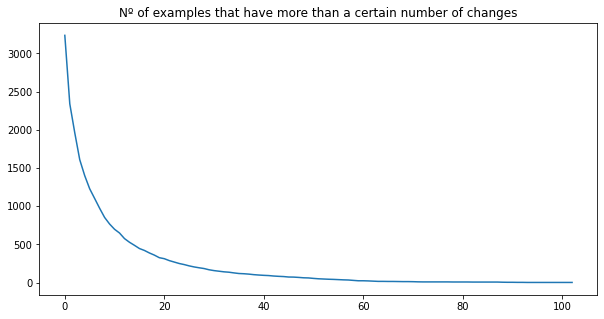

In [ ]:
df_changes, product_id_ord = get_ordered_number_of_changes(df, "product_id", "timestamp", "price_clean")

counts = []
for i in range(min(df_changes), max(df_changes)):
  counts.append(len(df_changes[df_changes > i]))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(counts)
#ax.set_yscale('log')
plt.title("Nº of examples that have more than a certain number of changes");

### Visualize time series

In [ ]:
product_id = [product_id_ord[0]]
df_product, info = select_time_series(df, "product_id", product_id)

product_group_id = info["product_group_id"]
company_id = info["company_id"]

Number of samples:  417


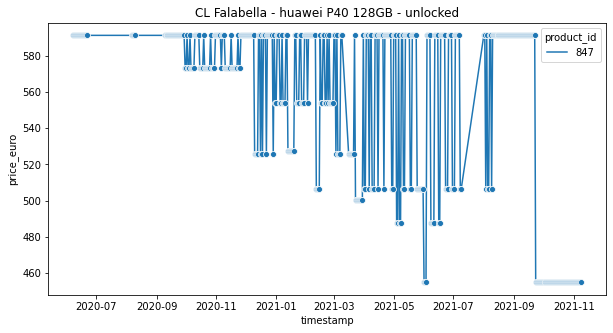

In [ ]:
show_time_series(df_product, "product_id", info)

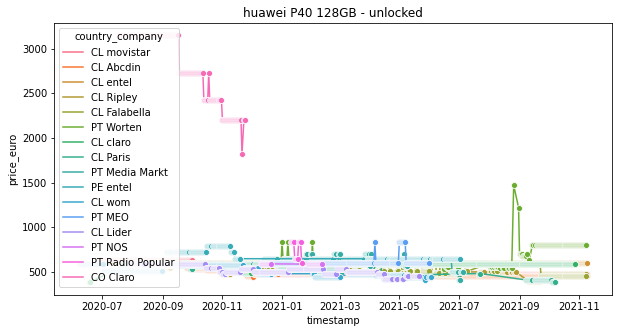

In [ ]:
df_product_group, info = select_time_series(df, "product_group_id", product_group_id)
show_time_series(df_product_group, "product_group_id", info)

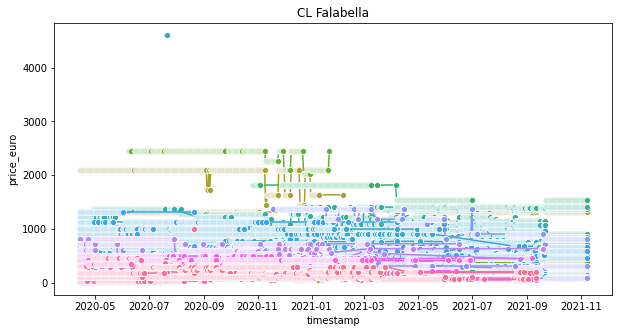

In [ ]:
df_company, info = select_time_series(df, "company_id", company_id)
show_time_series(df_company, "company_id", info)

### Naive Models

Select time series

In [ ]:
df[df["product"] == "lg Velvet 128GB"]

,country_company,company_id,product_group_id,product_id,product,country,company,price,timestamp,offer_type,currency,price_clean,price_euro
429446,CL movistar,13,670,2300,lg Velvet 128GB,CL,movistar,"$349,990",2021-11-09,unlocked,$,349.99,318.375330
429447,CL Abcdin,14,670,2301,lg Velvet 128GB,CL,Abcdin,"$349,990",2021-11-09,unlocked,$,349.99,318.375330
429448,CL movistar,13,670,2300,lg Velvet 128GB,CL,movistar,"$349,990",2021-11-08,unlocked,$,349.99,318.375330
429449,CL Falabella,1,670,2302,lg Velvet 128GB,CL,Falabella,"$299,990",2021-11-08,unlocked,$,299.99,272.891840
429450,CL Abcdin,14,670,2301,lg Velvet 128GB,CL,Abcdin,"$349,990",2021-11-08,unlocked,$,349.99,318.375330
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431892,CO Claro,5,670,2311,lg Velvet 128GB,CO,Claro,"$3,326,900",2020-09-29,unlocked,$,3326.90,3026.380424
431893,CO Claro,5,670,2311,lg Velvet 128GB,CO,Claro,"$3,326,900",2020-09-28,unlocked,$,3326.90,3026.380424
431894,CO Claro,5,670,2311,lg Velvet 128GB,CO,Claro,"$3,326,900",2020-09-27,unlocked,$,3326.90,3026.380424
431895,CO Claro,5,670,2311,lg Velvet 128GB,CO,Claro,"$3,326,900",2020-09-26,unlocked,$,3326.90,3026.380424


Number of samples:  399


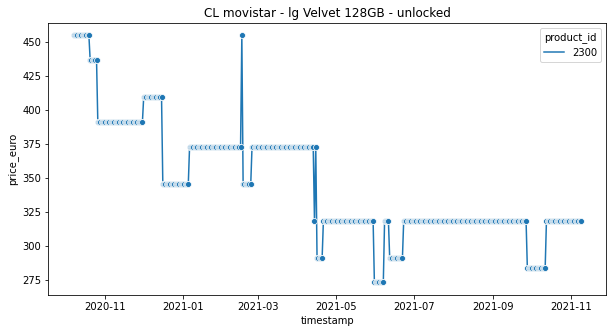

In [ ]:
#product_id = [product_id_ord[0]]
product_id = [2300]
df_product, info = select_time_series(df, "product_id", product_id)
show_time_series(df_product, "product_id", info)
df_product = prepare_time_series_univariate(df_product, price = "price_euro")

[Text(0, 0.5, 'Price/€'), Text(0.5, 0, 'Timestamp')]

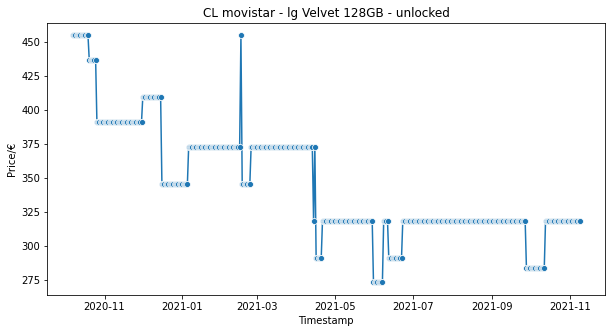

In [ ]:
df_product
p = sns.lineplot(data = df_product, x = "timestamp", y = "price_euro", marker = 'o')
p.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
p.set(xlabel='Timestamp', ylabel='Price/€')

##### Naive Models

###### Average

In [ ]:
class AVERAGE:
  def __init__(self):
    pass

  def get_prediction(self, data):
    
    self.data = data.copy()
    self.beg = 1

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = np.mean(self.data.iloc[:i])

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(7,5))
    ax.set(title=info["product"][0] + " - Average Prediction", xlabel='Timestamp', ylabel='Price/€')

    # Plot data points
    p = self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    p = self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    p.set(title=info["product"][0] + " - Average Prediction", xlabel='Timestamp', ylabel='Price/€')
    legend = ax.legend(loc='upper right')

<class 'numpy.float64'>
NNMSE:-18.393763656222667
Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_averageTimeseries.


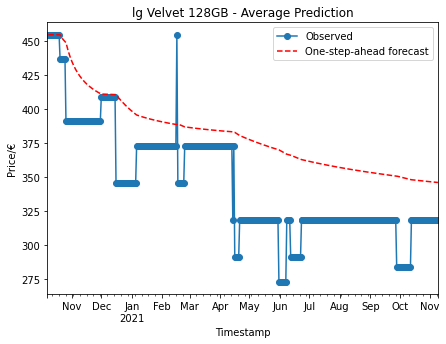

In [ ]:
average_model = AVERAGE()
y_pred = average_model.get_prediction(df_product["price_euro"])
nmse = average_model.get_metric(get_nmse)
print(type(nmse))
print("NNMSE:" + str(nmse))
average_model.plot_results()

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "averageTimeseries")

###### Repeat

In [ ]:
class REPEAT:
  def __init__(self):
    pass

  def get_prediction(self, data):
    
    self.data = data.copy()
    self.beg = 1

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = self.data.iloc[i-1]

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(3.1,2.5))
    ax.set(title=info["product"][0] + " - Repeat Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    p = self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    p.set(title=info["product"][0] + " - Repeat Prediction", xlabel='Timestamp', ylabel='Price/€')
    p.tick_params(labelrotation=90)
    legend = ax.legend(loc='upper right')

NNMSE:-29.994101034497778
Dissertação/Chapters/Imagens/Chapter_ArticleDETI/articledeti_naive_repeatTimeseries.


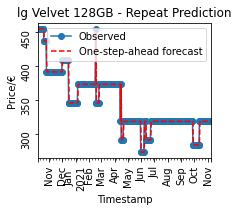

In [ ]:
repeat_model = REPEAT()
y_pred = repeat_model.get_prediction(df_product["price_euro"])
nmse = repeat_model.get_metric(get_nmse)
print("NNMSE:" + str(nmse))

# Graph
repeat_model.plot_results()

#save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "repeatTimeseries")
save_fig(plt, chapter_name = "ArticleDETI", section_name = "naive", name_of_fig = "repeatTimeseries")

###### Exponential Smoothing

In [ ]:
class EXPONENTIAL_SMOOTHING:
  def __init__(self):
    pass

  def get_prediction(self, data, smoothing_level):
    
    self.data = data.copy()
    self.beg = 11

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = SimpleExpSmoothing(self.data.iloc[:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast()

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    fig, ax = plt.subplots(figsize=(7,5))
    ax.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Date', ylabel='Price/€')

    # Plot data points
    self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    p = self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    p.set(title=info["product"][0] + " - Exponential Smoothing Prediction", xlabel='Timestamp', ylabel='Price/€')
    legend = ax.legend(loc='upper right')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_exponentialSmoothingTimeseries.


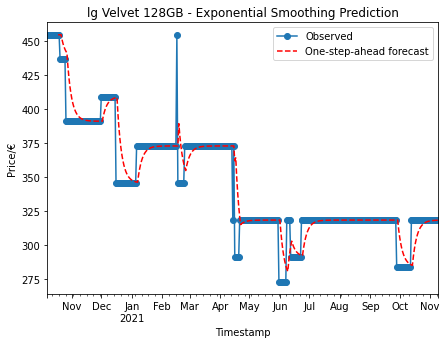

In [ ]:
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro")

exponential_model = EXPONENTIAL_SMOOTHING()
y_pred = exponential_model.get_prediction(df_product["price_euro"], smoothing_level = 0.2)
#nmse = exponential_model.get_metric(get_nmse)
#print("NNMSE:" + str(nmse))

# Graph
exponential_model.plot_results()

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "exponentialSmoothingTimeseries")

###### Average - Last Days

In [ ]:
class LAST_DAYS_AVERAGE:
  def __init__(self):
    pass

  def get_prediction(self, data, last_days):
    
    self.data = data.copy()
    self.beg = last_days + 1

    # Series to store one-step-ahead predictions
    self.pred = self.data.iloc[self.beg:].copy()
  
    # Total number of observed samples
    end = len(self.data)

    for i in range(self.beg, end):
      self.pred.iloc[i-self.beg] = np.mean(self.data.iloc[i-last_days:i])

    return self.pred

  def get_metric(self, metric):
    return metric(self.data.iloc[self.beg:], self.pred)

  def plot_results(self):

    #fig, ax = plt.subplots(figsize=(7,5))
    fig, ax = plt.subplots(figsize=(3.1,2.5))
    ax.set(title=info["product"][0] + " - Last 14 Days Average Prediction", xlabel='Timestamp', ylabel='Price/€')

    # Plot data points
    p = self.data.plot(ax=ax, style='-o', label='Observed')

    # Plot predictions
    p = self.pred.plot(ax=ax, style='r--', label='One-step-ahead forecast')
    #p.set(title=info["product"][0] +  " - Last 7 Days Average Prediction", xlabel='Timestamp', ylabel='Price/€')
    p.set(title="7-Day Moving Average Model", xlabel='Timestamp', ylabel='Price/€')
    p.tick_params(labelrotation=90)
    legend = ax.legend(loc='upper right')

<class 'numpy.float64'>
NNMSE:-27.91978348108664
Dissertação/Chapters/Imagens/Chapter_ArticleDETI/articledeti_naive_lastDaysAverageTimeseries.


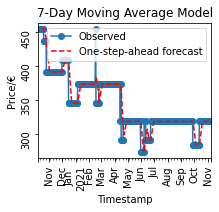

In [ ]:
average_model = LAST_DAYS_AVERAGE()
y_pred = average_model.get_prediction(df_product["price_euro"], last_days = 7)
nmse = average_model.get_metric(get_nmse)
print(type(nmse))
print("NNMSE:" + str(nmse))
average_model.plot_results()
   
save_fig(plt, chapter_name = "ArticleDETI", section_name = "naive", name_of_fig = "lastDaysAverageTimeseries")

##### Performance of models

In [ ]:
def get_model_performance(df):
  
  print(df["product_id"].unique()[0])

  if (len(df) < 30) | (0 in df["price_euro"].values):
    return np.nan, np.nan, np.nan

  data = prepare_time_series_univariate(df, interpolate_method = "ffill")

  # # REPEAT
  # repeat_model = REPEAT()
  # pred = repeat_model.get_prediction(data)
  # repeat_nmse = repeat_model.get_metric(get_nmse)

  # # AVERAGE
  # average_model = AVERAGE()
  # pred = average_model.get_prediction(data)
  # average_nmse = average_model.get_metric(get_nmse)

  # LAST DAYS AVERAGE
  last_days_average_model = LAST_DAYS_AVERAGE()
  y_pred = last_days_average_model.get_prediction(data, last_days = 7)
  last_days_7_nmse = last_days_average_model.get_metric(get_nmse)

  # LAST DAYS AVERAGE
  last_days_average_model = LAST_DAYS_AVERAGE()
  y_pred = last_days_average_model.get_prediction(data, last_days = 14)
  last_days_14_nmse = last_days_average_model.get_metric(get_nmse)

  # LAST DAYS AVERAGE
  last_days_average_model = LAST_DAYS_AVERAGE()
  y_pred = last_days_average_model.get_prediction(data, last_days = 21)
  last_days_21_nmse = last_days_average_model.get_metric(get_nmse)

  # # EXPONENTIAL SMOOTHING
  # exponential_smoothing = EXPONENTIAL_SMOOTHING()
  # pred = exponential_smoothing.get_prediction(data, smoothing_level = 0.2)
  # exponential_smoothing_nmse_02 = exponential_smoothing.get_metric(get_nmse)

  # # EXPONENTIAL SMOOTHING
  # exponential_smoothing = EXPONENTIAL_SMOOTHING()
  # pred = exponential_smoothing.get_prediction(data, smoothing_level = 0.4)
  # exponential_smoothing_nmse_04 = exponential_smoothing.get_metric(get_nmse)

  # # EXPONENTIAL SMOOTHING
  # exponential_smoothing = EXPONENTIAL_SMOOTHING()
  # pred = exponential_smoothing.get_prediction(data, smoothing_level = 0.6)
  # exponential_smoothing_nmse_06 = exponential_smoothing.get_metric(get_nmse)

  # # EXPONENTIAL SMOOTHING
  # exponential_smoothing = EXPONENTIAL_SMOOTHING()
  # pred = exponential_smoothing.get_prediction(data, smoothing_level = 0.8)
  # exponential_smoothing_nmse_08 = exponential_smoothing.get_metric(get_nmse)

  return last_days_7_nmse, last_days_14_nmse, last_days_21_nmse


length_timeseries = df.groupby(by = "product_id").size()
df_summary, product_id_ord = get_ordered_number_of_changes(df, "product_id", "timestamp" , "price_clean")
df_summary = pd.concat([length_timeseries, df_summary], axis=1)
df_summary.columns = ["n_samples", "n_changes"]

df_sub, info = select_time_series(df, "product_id", range(1,10))
#models_performances = df_sub.groupby("product_id").apply(get_model_performance)
models_performances = df.groupby("product_id").apply(get_model_performance)
index = models_performances.index
models_performances = np.stack(models_performances.to_numpy())
models_performances = pd.DataFrame(models_performances.reshape(models_performances.shape[0], models_performances.shape[1]), columns = ["last_days_7_nmse", "last_days_14_nmse", "last_days_21_nmse"]).set_index(index)
df_summary = pd.concat([df_summary, models_performances], axis = 1)

models_performances.reset_index()
models_performances.to_pickle("naive_results_fill_interpolation_last_days_average.pkl")

##### Get models performances

Obtain performace of models for all timeseries. The timeseries with 1 or 0 changes were discared, as they led to NMSEs of minus infinity. Either way, it's not interesting to perform predictions in timeseries with these kind of changes as there's none or barely none information in the timeseries.

In [ ]:
length_timeseries = df.groupby(by = "product_id").size()
df_summary, product_id_ord = get_ordered_number_of_changes(df, "product_id", "timestamp" , "price_clean")
df_summary = pd.concat([length_timeseries, df_summary], axis=1)
df_summary.columns = ["n_samples", "n_changes"]
df_summary["n_changes_over_n_samples"] = round(df_summary.n_changes/df_summary.n_samples, 2)

models_performances_smoothing = pd.read_pickle("naive_results_fill_interpolation_exponential_smoothing.pkl")
models_performances_last_days_average = pd.read_pickle("naive_results_fill_interpolation_last_days_average.pkl")
models_performances = pd.read_pickle("naive_results_fill_interpolation.pkl")

df_summary = pd.concat([df_summary, models_performances, models_performances_smoothing, models_performances_last_days_average], axis = 1)
df_summary = df_summary[df_summary["n_changes"] > 2]        # when repeat_nmse == inf, the number of changes is just 0 or 1. To avoid having these cases, just discard the lines with n_changes inferior to 2
df_summary_melt = pd.melt(df_summary, id_vars = ["n_samples", "n_changes", "n_changes_over_n_samples"], var_name = "models", value_name = "nmse")

Comparison of all naive models

In [ ]:
df_summary_mean = df_summary.dropna().mean().iloc[2:]

new_index = list(df_summary.columns)
new_index.remove("n_changes")
new_index.remove("n_samples")
new_index.remove("n_changes_over_n_samples")

new_index = ['average_nmse',
             'last_days_21_nmse', 'last_days_14_nmse', 'last_days_7_nmse',
             'exponential_smoothing_nmse_02', 'exponential_smoothing_nmse_04', 'exponential_smoothing_nmse_06', 'exponential_smoothing_nmse_08',
             'repeat_nmse']

df_summary_mean = df_summary_mean.reindex(new_index)
df_summary_mean

average_nmse                    -22.683569
last_days_21_nmse               -27.174654
last_days_14_nmse               -27.889055
last_days_7_nmse                -29.399747
exponential_smoothing_nmse_02   -28.706414
exponential_smoothing_nmse_04   -29.709876
exponential_smoothing_nmse_06   -30.086587
exponential_smoothing_nmse_08   -30.213235
repeat_nmse                     -32.466152
dtype: float64

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_meanNMSENaiveModels.


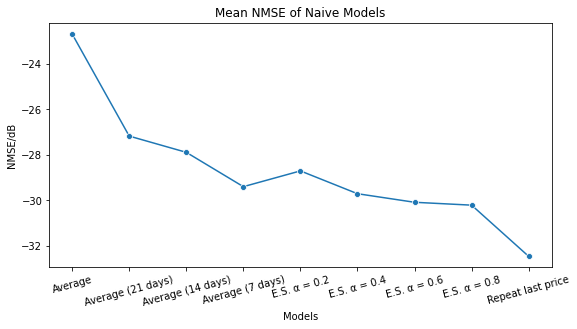

In [ ]:
models = ['Average', 'Average (21 days)', 'Average (14 days)', 'Average (7 days)',
          'E.S. α = 0.2', 'E.S. α = 0.4', 'E.S. α = 0.6', 'E.S. α = 0.8',
          'Repeat last price']
          
set_fig_size((9,4.5))
p = sns.lineplot(data = df_summary_mean, x = df_summary_mean.index, y = df_summary_mean.values, marker = 'o')
p.set(xlabel = "Models", ylabel = 'NMSE/dB', title = "Mean NMSE of Naive Models")
p.set_xticklabels(models, rotation = 15)

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "meanNMSENaiveModels")

Due to the constant nature of these timeseries and the abrupt changes, it was expected that the model that repeats the last price had the best performance. From the above graph, it is possible to see that as less previous days are considered in the calculation, the lower NMSE we have.

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_ratePriceChangeNaiveModels.


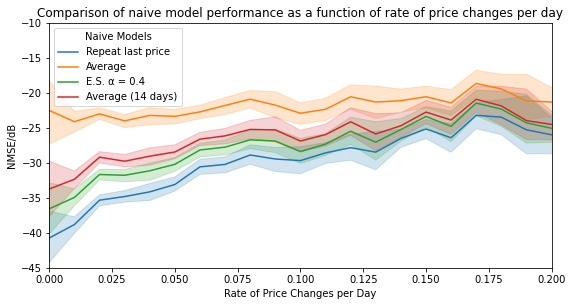

In [ ]:
models = ['Repeat last price', 'Average', 'E.S. α = 0.4', 'Average (14 days)']
df_summary_sel = df_summary_melt[df_summary_melt.models.isin(["repeat_nmse", 'last_days_14_nmse', 'exponential_smoothing_nmse_04', "average_nmse"])]

set_fig_size((9,4.5))
p = sns.lineplot(data = df_summary_sel, x = "n_changes_over_n_samples", y = "nmse", hue = "models")
p.set(ylim=(-45, -10), xlim = (0, 0.2), title = "Comparison of naive model performance as a function of rate of price changes per day", xlabel = "Rate of Price Changes per Day", ylabel = "NMSE/dB");
p.legend(title = 'Naive Models', loc = 'upper left', labels = models)

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "ratePriceChangeNaiveModels")

As the rate of price changes increase, the distance between the models' performance also diminishes. The confidence intervals increase because there are less samples as the rate of price changes increases. The repeat model works best in those timeseries where there are less changes. However, the repeat model is always best than the others, only much later do the confidence intervals really overlap.

Comparison of repeat with exponential smoothing

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_comparisonRepeatExpSmoothing.


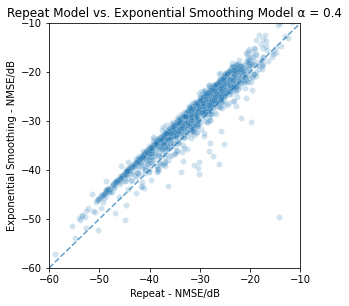

In [ ]:
lim_u = -60
lim_o = -10
set_fig_size((4.5, 4.5))
p = sns.scatterplot(data = df_summary, x = "repeat_nmse", y = "exponential_smoothing_nmse_04", alpha = 0.2)
p.plot([lim_u, lim_o], [lim_u, lim_o], linestyle='dashed', alpha = 0.7)
p.set(ylim=(lim_u, lim_o))
p.set(xlim=(lim_u, lim_o))
p.set(title = "Repeat Model vs. Exponential Smoothing Model α = 0.4", xlabel = "Repeat - NMSE/dB", ylabel = "Exponential Smoothing - NMSE/dB")


#p.legend(title='Number of Changes', loc='lower right')

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "comparisonRepeatExpSmoothing")

Comparison of repeat with average

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_comparisonRepeatAverage.


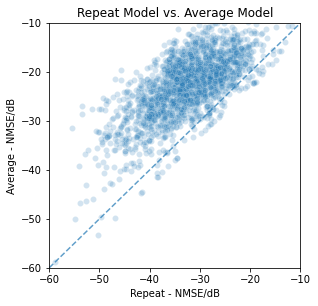

In [ ]:
lim_u = -60
lim_o = -10
set_fig_size((4.5, 4.5))
p = sns.scatterplot(data = df_summary, x = "repeat_nmse", y = "average_nmse", alpha = 0.2)
p.plot([lim_u, lim_o], [lim_u, lim_o], linestyle='dashed', alpha = 0.7)
p.set(ylim=(lim_u, lim_o))
p.set(xlim=(lim_u, lim_o))
p.set(title = "Repeat Model vs. Average Model", xlabel = "Repeat - NMSE/dB", ylabel = "Average - NMSE/dB")
#p.legend(title='Number of Changes', loc='lower right')

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "comparisonRepeatAverage")

Comparison of repeat with average last days

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_comparisonRepeatAverage14days.


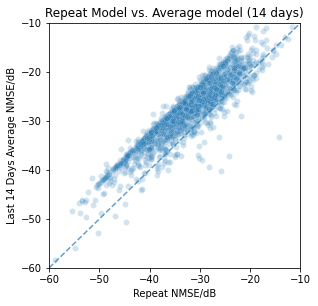

In [ ]:
lim_u = -60
lim_o = -10
set_fig_size((4.5, 4.5))
p = sns.scatterplot(data = df_summary, x = "repeat_nmse", y = "last_days_14_nmse", alpha = 0.2)
p.plot([lim_u, lim_o], [lim_u, lim_o], linestyle='dashed', alpha = 0.7)
p.set(ylim=(lim_u, lim_o))
p.set(xlim=(lim_u, lim_o))
p.set(title = "Repeat Model vs. Average model (14 days)", xlabel = "Repeat NMSE/dB", ylabel = "Last 14 Days Average NMSE/dB")
#p.legend(title='Number of Changes', loc='lower right')

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "comparisonRepeatAverage14days")

Check what type of timeseries have worse performances in the repeat model

In [ ]:
average_better_repeat = df_summary[df_summary.average_nmse < df_summary.repeat_nmse-1]
average_better_repeat_index = average_better_repeat.index
print("Average better repeat: ", len(average_better_repeat))
print("Repeat better average: ", len(df_summary) - len(average_better_repeat))

Average better repeat:  50
Repeat better average:  1910


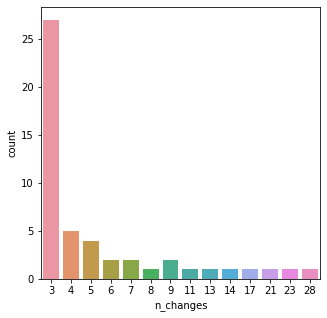

In [ ]:
set_fig_size((5,5))
sns.countplot(data = average_better_repeat, x = "n_changes")

Average model is better than repeat model in the situation where there abrupt changes that are imediately reverted.

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_repeatWorseExample1.


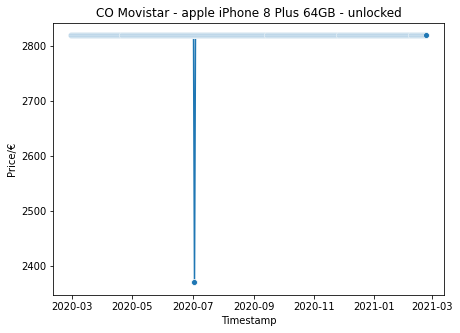

In [ ]:
product_id = [average_better_repeat_index[-15]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro")

set_fig_size((7,5))
p = sns.lineplot(data = df_product, x = "timestamp", y = "price_euro", marker = 'o')
p.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
p.set(xlabel='Timestamp', ylabel='Price/€')

save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "repeatWorseExample1")

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_repeatWorseExample1wModel.


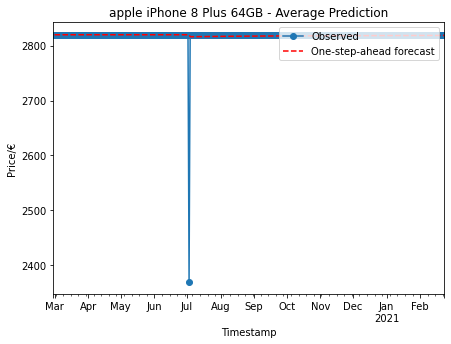

In [ ]:
average_model = AVERAGE()
y_pred = average_model.get_prediction(df_product["price_euro"])
average_model.plot_results()
save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "repeatWorseExample1wModel")

Check what type of timeseries have worse performances in the repeat model

In [ ]:
exp_better_repeat = df_summary[df_summary.exponential_smoothing_nmse_04 < df_summary.repeat_nmse-1].sort_values(by = "n_changes")
exp_better_repeat_index = exp_better_repeat.index
print("Exp better repeat: ", len(exp_better_repeat))
print("Repeat better exp: ", len(df_summary) - len(exp_better_repeat))

Exp better repeat:  95
Repeat better exp:  1865


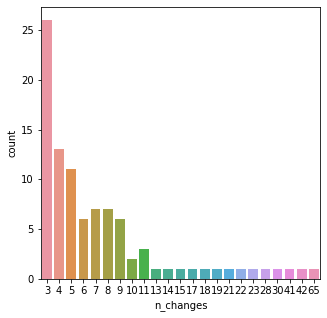

In [ ]:
set_fig_size((5,5))
sns.countplot(data = exp_better_repeat, x = "n_changes")

Exponential smoothing works a little better than the average model and than the repeat model, in the case where there are a lot of sudden changes. In this case, repeat will always be wrong, and the average model can't adjust fast enough to these changes.

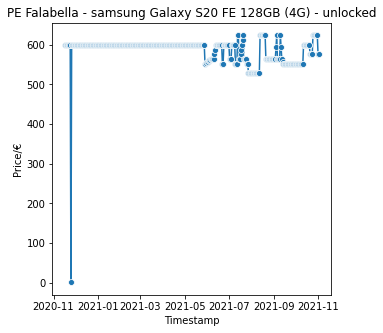

In [ ]:
product_id = [exp_better_repeat_index[-5]]
df_product, info = select_time_series(df, "product_id", product_id)
df_product = prepare_time_series_univariate(df_product, price = "price_euro")

p = sns.lineplot(data = df_product, x = "timestamp", y = "price_euro", marker = 'o')
p.set_title(info["country_company"][0] + " - " + info["product"][0] + " - " + info["offer_type"][0])
p.set(xlabel='Timestamp', ylabel='Price/€')

plt.savefig('Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naiveModels_repeatWorseExample2.svg')
plt.savefig('Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naiveModels_repeatWorseExample2.png')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_repeatWorseExample2wModel.


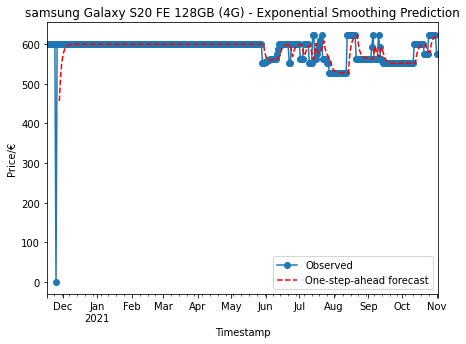

In [ ]:
exponential_model = EXPONENTIAL_SMOOTHING()
y_pred = exponential_model.get_prediction(df_product["price_euro"], smoothing_level = 0.4)
exponential_model.plot_results()
save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "repeatWorseExample2wModel")

In [ ]:
product_id_lst = list(df_flt.index.get_level_values(0).unique())
info_repeat = []

for product_id in product_id_lst:

  repeat_model = REPEAT()
  y_pred = repeat_model.get_prediction(df_flt.price_euro.loc[product_id])
  info = {"product_id": product_id,
          "pred_repeat" : y_pred}
  info_repeat.append(info)

info_repeat = pd.DataFrame(info_repeat).set_index("product_id")
info_repeat.to_pickle("naive_model_repeat_observations.pkl")

##### Several days forecast

###### Read data

In [ ]:
def get_features_df_product_group_id(df, feature_types, max_lag, min_lag = 1):

  # Lag timeseries
  for feature_type in feature_types:
    for lag in range(min_lag, max_lag+1):
      df[feature_type + "_lag_" + str(lag)] = df.groupby(by = "product_id")[feature_type].shift(lag)

  df = df.dropna()

  # Missing values
  df["price_euro_mv"] = df["price_euro"].where(df["out_of_stock"] == 0, np.nan) 

  return df

def create_prophet_model(data, hyper_parameters, country, regressors = []):
  
  m = Prophet(changepoint_prior_scale = hyper_parameters["changepoint_prior_scale"], weekly_seasonality = False, yearly_seasonality = False)

  # Add linear regressors
  if hyper_parameters["lagged_series"] == 1:
    if len(regressors) == 0:
      print("WARNING: NO REGRESSORS FOUND!")
    for regressor in regressors:
      m.add_regressor(regressor)

  # Seasonality
  if hyper_parameters["fourier_order"] != 0:
    m.add_seasonality(name='weekly', period=7, fourier_order = hyper_parameters["fourier_order"])
    m.add_seasonality(name='monthly', period=30.5, fourier_order = hyper_parameters["fourier_order"])      

  # Missing values
  if hyper_parameters["missing_values"] == 0:
    data["y"] = data["price_euro"]
  else:
    data["y"] = data["price_euro_mv"]

  # Holidays
  if hyper_parameters["holidays"] == 1:
    m.add_country_holidays(country_name = country)

  return data, m


def generate_regressors(feature_types, max_lag, min_lag = 1):
  regressors = []
  for feature in feature_types:
    for lag in range(min_lag, max_lag+1):
      regressor = feature + "_lag_" + str(lag)
      regressors.append(regressor)
  return regressors

In [ ]:
df_all = pd.read_pickle("df_all")
df = df_all.copy()
df = get_features_df_product_group_id(df, feature_types = ["price_euro"], max_lag = 14)

n_samples = df.dropna().groupby(by = "product_id").count().price_euro
n_changes = df.dropna()["diff"]
n_changes = n_changes[n_changes != 0].groupby(by = "product_id").count()
n_samples = n_samples.loc[n_changes.index]

n_samples_flt = n_samples[n_samples > 3*30.5]
n_changes_flt = n_changes.loc[n_samples_flt.index]
n_changes_flt = n_changes_flt[n_changes_flt > 5]
n_samples_flt = n_samples_flt.loc[n_changes_flt.index]

changes_samples_ratio = n_changes_flt/n_samples_flt

product_id_lst = list(n_changes_flt.index)

len(product_id_lst)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


922

###### Get model performances

In [ ]:
# Get nmse evolution with the number of days
def performance_metrics_self(df_cv):
  
  df_cv = df_cv.copy()
  df_cv["horizon"] = df_cv["ds"] - df_cv["cutoff"]
  df_cv["horizon_int"] = df_cv["horizon"].apply(lambda horizon: horizon.days)
  df_p = df_cv.groupby(by = "horizon")[["y", "yhat"]].apply(lambda x : get_nmse(x["y"], x["yhat"]))
  df_p = pd.DataFrame(df_p)
  df_p.columns = ["nmse"]
  df_p["n_samples_in_horizon"] = df_cv.groupby(by = "horizon").size()
  
  if "yhat_upper" in df_cv.columns:
    df_p["conf_int_width"] = df_cv.groupby(by = "horizon")[["yhat_lower", "yhat_upper"]].apply(lambda x : np.mean(x["yhat_upper"] - x["yhat_lower"]))
    df_p["conf_int_width_normalized"] = df_cv.groupby(by = "horizon")[["y", "yhat_lower", "yhat_upper"]].apply(lambda x : np.mean((x["yhat_upper"] - x["yhat_lower"])/np.mean(x["y"])))
  
  df_p = df_p.reset_index()

  df_p["horizon_int"] = df_p["horizon"].apply(lambda horizon: horizon.days)
  
  return df_p

In [ ]:
# Get df_cv for repeat model
def repeat_cross_validation(timeseries, initial, period, horizon):
  
  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    repeat_value = timeseries.iloc[i-1]
    obs = timeseries.iloc[i:i+horizon]
    pred = np.ones(len(obs))*repeat_value

    result = {"y": obs,
              "yhat": pred,
              "ds": obs.index,
              "cutoff": timeseries.index[i-1]}
    
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)

# Get df_cv for repeat model
def exponential_smoothing_cross_validation(timeseries, initial, period, horizon, smoothing_level):

  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    warnings.filterwarnings(action='once')
    obs = timeseries.iloc[i:i+horizon]
    warnings.simplefilter('ignore')
    pred = SimpleExpSmoothing(timeseries.iloc[i-initial-1:i-1], initialization_method="heuristic").fit(smoothing_level=smoothing_level, optimized=False).forecast(len(obs)).to_numpy()
    warnings.simplefilter('always')
    result = {"y": obs,
              "yhat": pred,
              "ds": obs.index,
              "cutoff": timeseries.index[i-1]}
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)


# Get df_cv for repeat model
def average_last_days_cross_validation(timeseries, initial, period, horizon, last_days):

  results = []
  for i in range(initial+1, len(timeseries)-horizon, period):
    
    warnings.filterwarnings(action='once')
    obs = timeseries.iloc[i:i+horizon]
    warnings.simplefilter('ignore')
    pred = np.mean(timeseries.iloc[i-last_days-1:i-1])
    warnings.simplefilter('always')
    result = {"y": obs,
              "yhat": pred,
              "ds": obs.index,
              "cutoff": timeseries.index[i-1]}
              
    results.append(pd.DataFrame(result))

  return pd.concat(results).reset_index().drop("timestamp", axis = 1)

In [ ]:
count = 0
initial = 15
period = 5
horizon = 60
all_info_repeat = []


for product_id in product_id_lst:

  count = count+1  
  print(str(count) + "/" + str(len(product_id_lst)))

  timeseries = pd.DataFrame(df.loc[product_id].reset_index()[["timestamp", "price_euro"]].set_index("timestamp")).price_euro
  df_cv = repeat_cross_validation(timeseries, initial, period, horizon)
  df_p  = performance_metrics_self(df_cv)

  info = {"product_id": product_id,
          "performance_metrics": df_p,
          "cross_validation_results": df_cv,
          "cross_validation_initial": initial,
          "cross_validation_horizon": horizon}

  all_info_repeat.append(info)

all_info_repeat = pd.DataFrame(all_info_repeat)
all_info_repeat.to_pickle("naive_predictions_univariate_repeat_period_" + str(period))

1/922
2/922
3/922
4/922
5/922
6/922
7/922
8/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


9/922
10/922
11/922
12/922
13/922
14/922
15/922
16/922
17/922
18/922
19/922
20/922
21/922
22/922
23/922
24/922
25/922
26/922
27/922
28/922
29/922
30/922
31/922
32/922
33/922
34/922
35/922
36/922
37/922
38/922
39/922
40/922
41/922
42/922
43/922
44/922
45/922
46/922
47/922
48/922
49/922
50/922
51/922
52/922
53/922
54/922
55/922
56/922
57/922
58/922
59/922
60/922
61/922
62/922
63/922
64/922
65/922
66/922
67/922
68/922
69/922
70/922
71/922
72/922
73/922
74/922
75/922
76/922
77/922
78/922
79/922
80/922
81/922
82/922
83/922
84/922
85/922
86/922
87/922
88/922
89/922
90/922
91/922
92/922
93/922
94/922
95/922
96/922
97/922
98/922
99/922
100/922
101/922
102/922
103/922
104/922
105/922
106/922
107/922
108/922
109/922
110/922
111/922
112/922
113/922
114/922
115/922
116/922
117/922
118/922
119/922
120/922
121/922
122/922
123/922
124/922
125/922
126/922
127/922
128/922
129/922
130/922
131/922
132/922
133/922
134/922
135/922
136/922
137/922
138/922
139/922
140/922
141/922
142/922
143/922
144/922
145/

In [ ]:
count = 0
initial = 15
period = 5
horizon = 60
all_info_exp = []

smoothing_levels = [0.8, 0.2]

for smoothing_level in smoothing_levels:

  all_info_exp = []
  count = 0

  for product_id in product_id_lst:

    count = count+1  
    print(str(count) + "/" + str(len(product_id_lst)))

    timeseries = pd.DataFrame(df.loc[product_id].reset_index()[["timestamp", "price_euro"]].set_index("timestamp")).price_euro
    df_cv = exponential_smoothing_cross_validation(timeseries, initial, period, horizon, smoothing_level = 0.5)
    df_p  = performance_metrics_self(df_cv)

    info = {"product_id": product_id,
            "performance_metrics": df_p,
            "cross_validation_results": df_cv,
            "cross_validation_initial": initial,
            "cross_validation_horizon": horizon}

    all_info_exp.append(info)

  all_info_exp = pd.DataFrame(all_info_exp)
  all_info_exp.to_pickle("naive_predictions_univariate_expSmooth_period_" + str(period) + "_smoothingLevel_" + str(smoothing_level))

1/922
2/922
3/922
4/922
5/922
6/922
7/922
8/922
9/922
10/922
11/922
12/922
13/922
14/922
15/922
16/922
17/922
18/922
19/922
20/922
21/922
22/922
23/922
24/922
25/922
26/922
27/922
28/922
29/922
30/922
31/922
32/922
33/922
34/922
35/922
36/922
37/922
38/922
39/922
40/922
41/922
42/922
43/922
44/922
45/922
46/922
47/922
48/922
49/922
50/922
51/922
52/922
53/922
54/922
55/922
56/922
57/922
58/922
59/922
60/922
61/922
62/922
63/922
64/922
65/922
66/922
67/922
68/922
69/922
70/922
71/922
72/922
73/922
74/922
75/922
76/922
77/922
78/922
79/922
80/922
81/922
82/922
83/922
84/922
85/922
86/922
87/922
88/922
89/922
90/922
91/922
92/922
93/922
94/922
95/922
96/922
97/922
98/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

99/922
100/922
101/922
102/922
103/922
104/922
105/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

106/922
107/922
108/922
109/922
110/922
111/922
112/922
113/922
114/922
115/922
116/922
117/922
118/922
119/922
120/922
121/922
122/922
123/922
124/922
125/922
126/922
127/922
128/922
129/922
130/922
131/922
132/922
133/922
134/922
135/922
136/922
137/922
138/922
139/922
140/922
141/922
142/922
143/922
144/922
145/922
146/922
147/922
148/922
149/922
150/922
151/922
152/922
153/922
154/922
155/922
156/922
157/922
158/922
159/922
160/922
161/922
162/922
163/922
164/922
165/922
166/922
167/922
168/922
169/922
170/922
171/922
172/922
173/922
174/922
175/922
176/922
177/922
178/922
179/922
180/922
181/922
182/922
183/922
184/922
185/922
186/922
187/922
188/922
189/922
190/922
191/922
192/922
193/922
194/922
195/922
196/922
197/922
198/922
199/922
200/922
201/922
202/922
203/922
204/922
205/922
206/922
207/922
208/922
209/922
210/922
211/922
212/922
213/922
214/922
215/922
216/922
217/922
218/922
219/922
220/922
221/922
222/922
223/922
224/922
225/922
226/922
227/922
228/922
229/922
230/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


807/922
808/922
809/922
810/922
811/922
812/922
813/922
814/922
815/922
816/922
817/922
818/922
819/922
820/922
821/922
822/922
823/922
824/922
825/922
826/922
827/922
828/922
829/922
830/922
831/922
832/922
833/922
834/922
835/922
836/922
837/922
838/922
839/922
840/922
841/922
842/922
843/922
844/922
845/922
846/922
847/922
848/922
849/922
850/922
851/922
852/922
853/922
854/922
855/922
856/922
857/922
858/922
859/922
860/922
861/922
862/922
863/922
864/922
865/922
866/922
867/922
868/922
869/922
870/922
871/922
872/922
873/922
874/922
875/922
876/922
877/922
878/922
879/922
880/922
881/922
882/922
883/922
884/922
885/922
886/922
887/922
888/922
889/922
890/922
891/922
892/922
893/922
894/922
895/922
896/922
897/922
898/922
899/922
900/922
901/922
902/922
903/922
904/922
905/922
906/922
907/922
908/922
909/922
910/922
911/922
912/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


913/922
914/922
915/922
916/922
917/922
918/922
919/922
920/922
921/922
922/922
1/922
2/922
3/922
4/922
5/922
6/922
7/922
8/922
9/922
10/922
11/922
12/922
13/922
14/922
15/922
16/922
17/922
18/922
19/922
20/922
21/922
22/922
23/922
24/922
25/922
26/922
27/922
28/922
29/922
30/922
31/922
32/922
33/922
34/922
35/922
36/922
37/922
38/922
39/922
40/922
41/922
42/922
43/922
44/922
45/922
46/922
47/922
48/922
49/922
50/922
51/922
52/922
53/922
54/922
55/922
56/922
57/922
58/922
59/922
60/922
61/922
62/922
63/922
64/922
65/922
66/922
67/922
68/922
69/922
70/922
71/922
72/922
73/922
74/922
75/922
76/922
77/922
78/922
79/922
80/922
81/922
82/922
83/922
84/922
85/922
86/922
87/922
88/922
89/922
90/922
91/922
92/922
93/922
94/922
95/922
96/922
97/922
98/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

99/922
100/922
101/922
102/922
103/922
104/922
105/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

106/922
107/922
108/922
109/922
110/922
111/922
112/922
113/922
114/922
115/922
116/922
117/922
118/922
119/922
120/922
121/922
122/922
123/922
124/922
125/922
126/922
127/922
128/922
129/922
130/922
131/922
132/922
133/922
134/922
135/922
136/922
137/922
138/922
139/922
140/922
141/922
142/922
143/922
144/922
145/922
146/922
147/922
148/922
149/922
150/922
151/922
152/922
153/922
154/922
155/922
156/922
157/922
158/922
159/922
160/922
161/922
162/922
163/922
164/922
165/922
166/922
167/922
168/922
169/922
170/922
171/922
172/922
173/922
174/922
175/922
176/922
177/922
178/922
179/922
180/922
181/922
182/922
183/922
184/922
185/922
186/922
187/922
188/922
189/922
190/922
191/922
192/922
193/922
194/922
195/922
196/922
197/922
198/922
199/922
200/922
201/922
202/922
203/922
204/922
205/922
206/922
207/922
208/922
209/922
210/922
211/922
212/922
213/922
214/922
215/922
216/922
217/922
218/922
219/922
220/922
221/922
222/922
223/922
224/922
225/922
226/922
227/922
228/922
229/922
230/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


807/922
808/922
809/922
810/922
811/922
812/922
813/922
814/922
815/922
816/922
817/922
818/922
819/922
820/922
821/922
822/922
823/922
824/922
825/922
826/922
827/922
828/922
829/922
830/922
831/922
832/922
833/922
834/922
835/922
836/922
837/922
838/922
839/922
840/922
841/922
842/922
843/922
844/922
845/922
846/922
847/922
848/922
849/922
850/922
851/922
852/922
853/922
854/922
855/922
856/922
857/922
858/922
859/922
860/922
861/922
862/922
863/922
864/922
865/922
866/922
867/922
868/922
869/922
870/922
871/922
872/922
873/922
874/922
875/922
876/922
877/922
878/922
879/922
880/922
881/922
882/922
883/922
884/922
885/922
886/922
887/922
888/922
889/922
890/922
891/922
892/922
893/922
894/922
895/922
896/922
897/922
898/922
899/922
900/922
901/922
902/922
903/922
904/922
905/922
906/922
907/922
908/922
909/922
910/922
911/922
912/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


913/922
914/922
915/922
916/922
917/922
918/922
919/922
920/922
921/922
922/922


In [ ]:
count = 0
initial = 15
period = 5
horizon = 60
all_info_exp = []

last_days = [14, 7, 5]

for last_day in last_days:

  all_info_exp = []
  count = 0

  for product_id in product_id_lst:

    count = count+1  
    print(str(count) + "/" + str(len(product_id_lst)))

    timeseries = pd.DataFrame(df.loc[product_id].reset_index()[["timestamp", "price_euro"]].set_index("timestamp")).price_euro
    df_cv = average_last_days_cross_validation(timeseries, initial, period, horizon, last_day)
    df_p  = performance_metrics_self(df_cv)

    info = {"product_id": product_id,
            "performance_metrics": df_p,
            "cross_validation_results": df_cv,
            "cross_validation_initial": initial,
            "cross_validation_horizon": horizon}

    all_info_exp.append(info)

  all_info_exp = pd.DataFrame(all_info_exp)
  all_info_exp.to_pickle("naive_predictions_univariate_average_period_" + str(period) + "_lastDays_" + str(last_day))

1/922
2/922
3/922
4/922
5/922
6/922
7/922
8/922
9/922
10/922
11/922
12/922
13/922
14/922
15/922
16/922
17/922
18/922
19/922
20/922
21/922
22/922
23/922
24/922
25/922
26/922
27/922
28/922
29/922
30/922
31/922
32/922
33/922
34/922
35/922
36/922
37/922
38/922
39/922
40/922
41/922
42/922
43/922
44/922
45/922
46/922
47/922
48/922
49/922
50/922
51/922
52/922
53/922
54/922
55/922
56/922
57/922
58/922
59/922
60/922
61/922
62/922
63/922
64/922
65/922
66/922
67/922
68/922
69/922
70/922
71/922
72/922
73/922
74/922
75/922
76/922
77/922
78/922
79/922
80/922
81/922
82/922
83/922
84/922
85/922
86/922
87/922
88/922
89/922
90/922
91/922
92/922
93/922
94/922
95/922
96/922
97/922
98/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

99/922
100/922
101/922
102/922
103/922
104/922
105/922
106/922
107/922
108/922
109/922
110/922
111/922
112/922
113/922
114/922
115/922
116/922
117/922
118/922
119/922
120/922
121/922
122/922
123/922
124/922
125/922
126/922
127/922
128/922
129/922
130/922
131/922
132/922
133/922
134/922
135/922
136/922
137/922
138/922
139/922
140/922
141/922
142/922
143/922
144/922
145/922
146/922
147/922
148/922
149/922
150/922
151/922
152/922
153/922
154/922
155/922
156/922
157/922
158/922
159/922
160/922
161/922
162/922
163/922
164/922
165/922
166/922
167/922
168/922
169/922
170/922
171/922
172/922
173/922
174/922
175/922
176/922
177/922
178/922
179/922
180/922
181/922
182/922
183/922
184/922
185/922
186/922
187/922
188/922
189/922
190/922
191/922
192/922
193/922
194/922
195/922
196/922
197/922
198/922
199/922
200/922
201/922
202/922
203/922
204/922
205/922
206/922
207/922
208/922
209/922
210/922
211/922
212/922
213/922
214/922
215/922
216/922
217/922
218/922
219/922
220/922
221/922
222/922
223/922
2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

100/922
101/922
102/922
103/922
104/922
105/922
106/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

107/922
108/922
109/922
110/922
111/922
112/922
113/922
114/922
115/922
116/922
117/922
118/922
119/922
120/922
121/922
122/922
123/922
124/922
125/922
126/922
127/922
128/922
129/922
130/922
131/922
132/922
133/922
134/922
135/922
136/922
137/922
138/922
139/922
140/922
141/922
142/922
143/922
144/922
145/922
146/922
147/922
148/922
149/922
150/922
151/922
152/922
153/922
154/922
155/922
156/922
157/922
158/922
159/922
160/922
161/922
162/922
163/922
164/922
165/922
166/922
167/922
168/922
169/922
170/922
171/922
172/922
173/922
174/922
175/922
176/922
177/922
178/922
179/922
180/922
181/922
182/922
183/922
184/922
185/922
186/922
187/922
188/922
189/922
190/922
191/922
192/922
193/922
194/922
195/922
196/922
197/922
198/922
199/922
200/922
201/922
202/922
203/922
204/922
205/922
206/922
207/922
208/922
209/922
210/922
211/922
212/922
213/922
214/922
215/922
216/922
217/922
218/922
219/922
220/922
221/922
222/922
223/922
224/922
225/922
226/922
227/922
228/922
229/922
230/922
231/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel

490/922
491/922
492/922
493/922
494/922
495/922
496/922
497/922
498/922
499/922
500/922
501/922
502/922
503/922
504/922
505/922
506/922
507/922
508/922
509/922
510/922
511/922
512/922
513/922
514/922
515/922
516/922
517/922
518/922
519/922
520/922
521/922
522/922
523/922
524/922
525/922
526/922
527/922
528/922
529/922
530/922
531/922
532/922
533/922
534/922
535/922
536/922
537/922
538/922
539/922
540/922
541/922
542/922
543/922
544/922
545/922
546/922
547/922
548/922
549/922
550/922
551/922
552/922
553/922
554/922
555/922
556/922
557/922
558/922
559/922
560/922
561/922
562/922
563/922
564/922
565/922
566/922
567/922
568/922
569/922
570/922
571/922
572/922
573/922
574/922
575/922
576/922
577/922
578/922
579/922
580/922
581/922
582/922
583/922
584/922
585/922
586/922
587/922
588/922
589/922
590/922
591/922
592/922
593/922
594/922
595/922
596/922
597/922
598/922
599/922
600/922
601/922
602/922
603/922
604/922
605/922
606/922
607/922
608/922
609/922
610/922
611/922
612/922
613/922
614/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


807/922
808/922
809/922
810/922
811/922
812/922
813/922
814/922
815/922
816/922
817/922
818/922
819/922
820/922
821/922
822/922
823/922
824/922
825/922
826/922
827/922
828/922
829/922
830/922
831/922
832/922
833/922
834/922
835/922
836/922
837/922
838/922
839/922
840/922
841/922
842/922
843/922
844/922
845/922
846/922
847/922
848/922
849/922
850/922
851/922
852/922
853/922
854/922
855/922
856/922
857/922
858/922
859/922
860/922
861/922
862/922
863/922
864/922
865/922
866/922
867/922
868/922
869/922
870/922
871/922
872/922
873/922
874/922
875/922
876/922
877/922
878/922
879/922
880/922
881/922
882/922
883/922
884/922
885/922
886/922
887/922
888/922
889/922
890/922
891/922
892/922
893/922
894/922
895/922
896/922
897/922
898/922
899/922
900/922
901/922
902/922
903/922
904/922
905/922
906/922
907/922
908/922
909/922
910/922
911/922
912/922


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


913/922
914/922
915/922
916/922
917/922
918/922
919/922
920/922
921/922
922/922


###### Analyze model performances

In [ ]:
def func_1(row, performance_metrics):
  tmp = row[performance_metrics].copy()
  tmp = tmp[["horizon_int", "nmse"]]
  tmp["product_id"] = row.name
  return tmp

In [ ]:
average_days_3 = pd.read_pickle("naive_predictions_univariate_average_period_5_lastDays_3")
average_days_7 = pd.read_pickle("naive_predictions_univariate_average_period_5_lastDays_7")
average_days_14 = pd.read_pickle("naive_predictions_univariate_average_period_5_lastDays_14")

exp_Smooth_02 = pd.read_pickle("naive_predictions_univariate_expSmooth_period_5_smoothingLevel_0.2")
exp_Smooth_08 = pd.read_pickle("naive_predictions_univariate_expSmooth_period_5_smoothingLevel_0.8")

repeat = pd.read_pickle("naive_predictions_univariate_repeat_period_5")

In [ ]:
average_days_3 = pd.concat(list(pd.DataFrame(average_days_3.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
average_days_3["model"] = "average_days_3"
average_days_3 = average_days_3[average_days_3.nmse > -500]

average_days_7 = pd.concat(list(pd.DataFrame(average_days_7.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
average_days_7["model"] = "average_days_7"
average_days_7 = average_days_7[average_days_7.nmse > -500]

average_days_14 = pd.concat(list(pd.DataFrame(average_days_14.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
average_days_14["model"] = "average_days_14"
average_days_14 = average_days_14[average_days_14.nmse > -500]

exp_Smooth_02 = pd.concat(list(pd.DataFrame(exp_Smooth_02.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
exp_Smooth_02["model"] = "exp_Smooth_02"
exp_Smooth_02 = exp_Smooth_02[exp_Smooth_02.nmse > -500]

exp_Smooth_08 = pd.concat(list(pd.DataFrame(exp_Smooth_08.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
exp_Smooth_08["model"] = "exp_Smooth_08"
exp_Smooth_08 = exp_Smooth_08[exp_Smooth_08.nmse > -500]

repeat = pd.concat(list(pd.DataFrame(repeat.performance_metrics).apply(lambda row : func_1(row, "performance_metrics"), axis = 1)))
repeat["model"] = "repeat"
repeat = repeat[repeat.nmse > -500]

In [ ]:
naive_predictions_days = pd.concat([repeat, exp_Smooth_08, exp_Smooth_02, average_days_3, average_days_14, average_days_7])
naive_predictions_days = naive_predictions_days[naive_predictions_days.horizon_int < 21]

In [ ]:
tmp["model"].rename({"repeat": "Repeat", "exp_Smooth_08" : "E.S. α = 0.8", "exp_Smooth_02" : "E.S. α = 0.2", "average_days_3" : "Average (3)", "average_days_7" : "Average (7)", "average_days_14" : "Average (14)"})

0             repeat
1             repeat
2             repeat
3             repeat
4             repeat
           ...      
15    average_days_7
16    average_days_7
17    average_days_7
18    average_days_7
19    average_days_7
Name: model, Length: 110188, dtype: object

Dissertação/Chapters/Imagens/Chapter_Prediction/prediction_naive_baselinePerformanceSeveralDays.


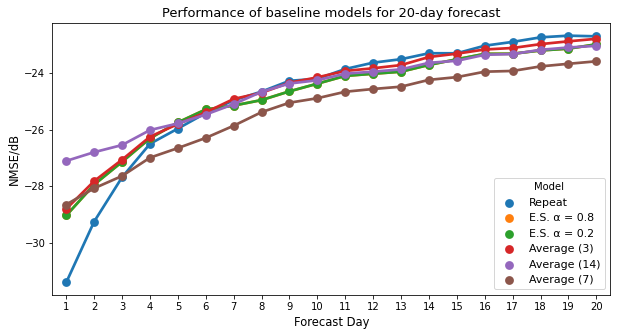

In [ ]:
fontsize = 13
set_fig_size((10, 5))
tmp = naive_predictions_days.copy()
tmp["model"] = tmp["model"].replace({"repeat": "Repeat", "exp_Smooth_08" : "E.S. α = 0.8", "exp_Smooth_02" : "E.S. α = 0.2", "average_days_3" : "Average (3)", "average_days_7" : "Average (7)", "average_days_14" : "Average (14)"})
p = sns.pointplot(data = tmp, x = "horizon_int", y = "nmse", hue = "model", ci = False, alpha = 0.5)
p.set_title("Performance of baseline models for 20-day forecast", fontsize = fontsize)
p.set_ylabel("NMSE/dB", fontsize = fontsize - 1.5)
p.set_xlabel("Forecast Day", fontsize = fontsize - 1.5)
p.legend(title = "Model", fontsize = fontsize-2)

# Save fig
save_fig(plt, chapter_name = "Prediction", section_name = "naive", name_of_fig = "baselinePerformanceSeveralDays")

In [ ]:
# À exceção das primeiras amostras, verifica-se que o average_days_7 e average_days_14 têm uma performance muito parecida. Não se fez testes mais extensos porque dava muito trabalho. Vai-se usar o average_days_7 porque tem melhor performance nos primeiros.

In [ ]:
for horizon_int in range(1, 61):
  print(horizon_int)
  print(f_oneway(naive_predictions_days[(naive_predictions_days.model == "average_days_14") & (naive_predictions_days.horizon_int == horizon_int)].nmse, naive_predictions_days[(naive_predictions_days.model == "average_days_7")  & (naive_predictions_days.horizon_int == horizon_int)].nmse))  
  print(stats.kruskal(naive_predictions_days[(naive_predictions_days.model == "average_days_14") & (naive_predictions_days.horizon_int == horizon_int)].nmse, naive_predictions_days[(naive_predictions_days.model == "average_days_7")  & (naive_predictions_days.horizon_int == horizon_int)].nmse))  

1
F_onewayResult(statistic=3.527146241036578, pvalue=0.06052955900791278)
KruskalResult(statistic=11.417489859510775, pvalue=0.0007275592664612888)
2
F_onewayResult(statistic=2.4231507081782886, pvalue=0.1197261345656296)
KruskalResult(statistic=6.73015377790629, pvalue=0.009479642696751216)
3
F_onewayResult(statistic=1.7743877110773107, pvalue=0.1830048706125936)
KruskalResult(statistic=3.736350298150283, pvalue=0.05324061768934692)
4
F_onewayResult(statistic=1.3770290552243523, pvalue=0.2407596489022894)
KruskalResult(statistic=2.0532770114318595, pvalue=0.15187897713256776)
5
F_onewayResult(statistic=1.1196240669415862, pvalue=0.29013823161068464)
KruskalResult(statistic=1.268478520512258, pvalue=0.2600523025609349)
6
F_onewayResult(statistic=1.0081274939365603, pvalue=0.315483800145955)
KruskalResult(statistic=0.8769894514431353, pvalue=0.3490275722715661)
7
F_onewayResult(statistic=1.2196320632697688, pvalue=0.26957718954435206)
KruskalResult(statistic=0.546484262019224, pvalue=0.